**Load & clean data**

In [ ]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Paths 
bike_path = "./datasets/SAMPLE_NYC_BIKE.csv"
ped_path  = "./datasets/Bi-Annual_Pedestrian_Counts.csv"

# Load raw data
bike = pd.read_csv(bike_path)
ped = pd.read_csv(ped_path)

print("Bike shape:", bike.shape)
print("Ped shape:", ped.shape)

# Clean bikeshare
# Parse start datetime
bike["start_datetime"] = pd.to_datetime(bike["started_at"], errors="coerce")

# Filter by year (your dataset is 2025)
bike = bike[(bike["start_datetime"].dt.year == 2025)].copy()

# Drop rows missing station info / coords
bike = bike.dropna(subset=["start_station_name", "end_station_name",
                           "start_lat", "start_lng", "end_lat", "end_lng"])

# restrict to NYC bounding box
nyc_mask = (
    (bike["start_lat"] >= 40.50) & (bike["start_lat"] <= 40.92) &
    (bike["start_lng"] >= -74.27) & (bike["start_lng"] <= -73.68)
)
bike = bike[nyc_mask].copy()

print("\nBike (NYC) rows:", len(bike))

# Extract temporal fields
bike["start_date"]  = bike["start_datetime"].dt.date
bike["start_hour"]  = bike["start_datetime"].dt.hour
bike["start_dow"]   = bike["start_datetime"].dt.dayofweek
bike["start_year"]  = bike["start_datetime"].dt.year
bike["start_month"] = bike["start_datetime"].dt.month

# Categorize AM/MD/PM for aggregation
def time_period(hour):
    if 6 <= hour < 12:
        return "AM"
    elif 12 <= hour < 18:
        return "MD"
    else:
        return "PM"
bike["time_period"] = bike["start_hour"].apply(time_period)

# -----------------------------
# Clean pedestrian data
# -----------------------------
# Extract spatial coords from 'the_geom' (POINT (lng lat))
ped[["lng", "lat"]] = ped["the_geom"].str.extract(r"POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)").astype(float)

# Create a station identifier for pedestrian data
ped["Station"] = ped["Street_Nam"] + " & " + ped["From_Stree"] + " / " + ped["To_Street"]

# Select relevant columns (Station, coords, AM/MD/PM counts)
count_cols = [c for c in ped.columns if "_AM" in c or "_MD" in c or "_PM" in c]
ped = ped[["Station", "lat", "lng"] + count_cols].copy()

# Melt AM/MD/PM counts into long format
ped_long = ped.melt(
    id_vars=["Station", "lat", "lng"],
    var_name="period_year",
    value_name="Counts"
)

# Extract period (AM/MD/PM) and year from column name
ped_long["time_period"] = ped_long["period_year"].str.split("_").str[-1]
ped_long["year"] = ped_long["period_year"].str.extract(r"(\d{2,4})")[0].astype(int)

# Keep only valid counts (>=0)
ped_long = ped_long.dropna(subset=["Counts"])
ped_long = ped_long[ped_long["Counts"] >= 0]

print("\nPed rows:", len(ped_long))
print("\nUnique ped stations:", ped_long["Station"].nunique())
print(ped_long["Station"].value_counts().head(10))


C:\Users\mkcru\AppData\Local\Temp\ipykernel_33036\2780854229.py:16: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  bike = pd.read_csv(bike_path)


Bike shape: (6000000, 14)
Ped shape: (114, 113)

Bike (NYC) rows: 5977248

Ped rows: 11742

Unique ped stations: 96
Station
Broadway & West 231st Street / Naples Terrace                 103
East 161st Street & Gra Concourse / Sheridan Avenue           103
East Fordham Road & Valentine Avenue / Tiebout Avenue         103
East Gun Hill Road & Bainbridge Avenue / Rochambeau Avenue    103
East Tremont Avenue & Prospect Avenue / Clinton Avenue        103
Gra Concourse & East 164th Street / East 165th Street         103
Third Avenue & East 150th Street / East 151st Street          103
White Plains Road & Pelham Parkway South / Lydig Avenue       103
5th Avenue & 51st Street / 52 Street                          103
5th Avenue & Union Street / President Street                  103
Name: count, dtype: int64


**Spatial Matching + Bike/Ped Hourly Aggregation**

In [34]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, asin, sqrt
import re

# -----------------------------
# Normalize pedestrian station names to match station_matches
# -----------------------------
def normalize_name(s):
    if pd.isna(s):
        return s
    s = s.strip()

    # Replace "&" with "@"
    s = s.replace(" & ", " @ ")

    # Replace "/" with " – "
    s = s.replace(" / ", " – ")

    # Collapse double spaces
    s = " ".join(s.split())

    return s


# ----------------------------
# Built-in coordinates 
# ----------------------------
PED_COORDS = {
    "Broadway @ West 231st Street – Naples Terrace": (40.87919896648574, -73.90459140730678),
    "East 161st Street @ Gra Concourse – Sheridan Avenue": (40.82662794123292, -73.92188432870218),
    "East Fordham Road @ Valentine Avenue – Tiebout Avenue": (40.86215460031517, -73.89535781584335),
    "East Gun Hill Road @ Bainbridge Avenue – Rochambeau Avenue": (40.8812869959873, -73.87892467324478),
    "East Tremont Avenue @ Prospect Avenue – Clinton Avenue": (40.844636776717664, -73.88956389732787),
    "Gra Concourse @ East 164th Street – East 165th Street": (40.83015855511035, -73.92087824799184),
    "Third Avenue @ East 150th Street – East 151st Street": (40.81688745834867, -73.91635737290386),
    "White Plains Road @ Pelham Parkway South – Lydig Avenue": (40.85558871971955, -73.86767352599497),
    "5th Avenue @ 51st Street – 52 Street": (40.64426682358741, -74.01119296689038),
    "5th Avenue @ Union Street – President Street": (40.676093537146265, -73.98067647018506),
    "7th Avenue @ 9th Street – 8th Street": (40.66717415129596, -73.98134205800814),
    "86th Street @ 4th Avenue – 5th Avenue": (40.622138829200395, -74.02728680504437),
    "Atlantic Avenue @ Boerum Place – Smith Street": (40.68884781602201, -73.98983165443038),
    "Bedford Avenue @ North 7th Street – North 6th Street": (40.71755737770773, -73.95802234844946),
    "Brighton Beach Avenue @ Brighton 4th Street – Brighton 5th Street": (40.57732714149917, -73.96276340616195),
    "Church Avenue @ Nostra Avenue – East 31st Street": (40.650831467717424, -73.94908133692475),
    "Cortelyou Road @ Argyle Road – Rugby Road": (40.64062739307868, -73.96573732115321),
    "Court Street @ Atlantic Avenue – Pacific Street": (40.68942537824676, -73.99249336775775),
    "Eastern Parkway @ Plaza Street East – Uerhill Avenue": (40.67292523719001, -73.96818725047231),
    "Flatbush Avenue @ Avenue U – Avenue V": (40.6089208214552, -73.9214952312361),
    "Flatbush Avenue @ Martense Street – Church Avenue": (40.650810536749546, -73.95882184227794),
    "Flatbush Avenue @ St. Marks Avenue – Prospect Place": (40.67918699313476, -73.97390965382397),
    "Fulton Street @ Lawrence Street – Bridge Street": (40.69087186438648, -73.98588670734839),
    "Graham Avenue @ Moore Street – Varet Street": (40.703408264633794, -73.94255463338305),
    "Gra Street @ Manhattan Avenue – Graham Avenue": (40.71156922033028, -73.9446668043415),
    "Jay Street @ Willoughby Street – Metrotech Walk": (40.69272414021878, -73.98727479290567),
    "Kings Highway @ East 13th Street – East 14th Street": (40.608201460936, -73.95959352755617),
    "Montague Street @ Henry Street – Clinton Street": (40.69453486150852, -73.99336426671383),
    "Myrtle Avenue @ Vaerbilt Avenue – Clinton Avenue": (40.693114646759874, -73.96931991427776),
    "Old Fulton Street @ Elizabeth Place – Everit Place": (40.702746482787724, -73.9939968076081),
    "Pitkin Avenue @ Bristol Street – Hopkinson Avenue": (40.669334561930114, -73.91307856842978),
    "Sheepshead Bay Road @ East 14th Street – East 15th Street": (40.58754340485192, -73.95475091689498),
    "VanBrunt Street @ Beard Street – Vaike Street": (40.67546559688342, -74.01511472616954),
    "Washington Street @ Front Street – Water Street": (40.70286152715002, -73.98960330219742),
    "Broad Street @ Beaver Street – South William Street": (40.70463665187375, -74.01155687409947),
    "Broadway @ Morris Street – Exchange Place": (40.70634164448271, -74.01286204592034),
    "Broadway @ West 63rd Street – West 64th Street": (40.7718134030119, -73.98219706247882),
    "Chambers Street @ West Broadway – Greenwich Street": (40.715904559004244, -74.01009312926121),
    "Columbus Avenue @ West 75th Street – West 76th Street": (40.77968082763136, -73.97713579908014),
    "Delancey Street @ Orchard Street – Ludlow Street": (40.718989359353586, -73.98936305063111),
    "East 14th Street @ Fifth Avenue – University Place": (40.73559926423828, -73.99265748471083),
    "East 42 Street @ Park Avenue – Lexington Avenue": (40.75169473512389, -73.97665547944715),
    "East 8th Street @ University Place – Greene Street": (40.731436017707075, -73.99441204702927),
    "Eighth Avenue @ West 44th Street – West 45th Street": (40.7588482835213, -73.98861503057542),
    "Fifth Avenue @ East 54th Street – East 55th Street": (40.761353610911776, -73.97514418621735),
    "Forsyth Street @ Canal Street – Division Street": (40.71493552371378, -73.99451531515767),
    "Fulton Street @ Broadway – Nassau Street": (40.71055376746076, -74.0084036486757),
    "Fulton Street @ Cliff Street – Pearl Street": (40.70806272095774, -74.00451806937401),
    "Lexington Avenue @ East 57th Street – East 58th Street": (40.761264607952285, -73.96888735867235),
    "Madison Avenue @ East 71st Street – East 72 Street": (40.77144062263456, -73.96568512678532),
    "Seventh Avenue @ West 32 Street – West 33rd Street": (40.749996387066574, -73.99134284997088),
    "Trinity Place @ Rector Street – Thames Street": (40.708351612740366, -74.01257537541983),
    "Wall Street @ New Street – Nassau Street": (40.70733537559069, -74.01098647762808),
    "West 125th Street @ Adam C. Powell Boulevard – Lenox Avenue": (40.80842973710492, -73.94703781905247),
    "West 14th Street @ Hudson Street – Eighth Avenue": (40.740305392828965, -74.00384095197924),
    "West 181st Street @ St. Nicholas Avenue – Wadsworth Avenue": (40.84958094443508, -73.93434784508338),
    "West 34th Street @ Broadway – Seventh Avenue": (40.75045405486473, -73.98934552114228),
    "West 40th Street @ Avenue of the Americas – Fifth Avenue": (40.752843606340384, -73.98335689692979),
    "West 47th Street @ Avenue of the Americas – Fifth Avenue": (40.757338486389926, -73.98017962622333),
    "Seco Avenue @ 50th Street – 51st Street": (40.755190220332366, -73.96829307507049),
    "Third Avenue @ 50th Street – 51st Street": (40.75613758564416, -73.97053303866996),
    "Lexington Avenue @ 50th Street – 51st Street": (40.756810835163854, -73.97213382742112),
    "Park Avenue @ 50th Street – 51st Street": (40.75753624831215, -73.97385284104773),
    "Madison Avenue @ 50th Street – 51st Street": (40.75817343083521, -73.97536263666144),
    "Fifth Avenue @ 50th Street – 51st Street": (40.75885135958746, -73.97697246269053),
    "Sixth Avenue @ 50th Street – 51st Street": (40.76021178450935, -73.98019868261785),
    "Seventh Avenue @ 50th Street – 51st Street": (40.76140611887666, -73.98303507483828),
    "Broadway @ 50th Street – 51st Street": (40.76174395517826, -73.98383919698608),
    "Eighth Avenue @ 50th Street – 51st Street": (40.76257065006476, -73.98589867014988),
    "Hudson River Greenway @ 50th Street – 51st Street": (40.7673124325193, -73.99694382805035),
    "165th Street @ 89th Avenue – Jamaica Avenue": (40.70653426935826, -73.79555468117455),
    "37th Avenue @ 73rd Street – 74th Street": (40.74891155301485, -73.89225364571111),
    "82 Street @ 37th Avenue – Roosevelt Avenue": (40.74873155074409, -73.88412639509386),
    "Austin Street @ 71st Ave – 70th Road": (40.720365744814835, -73.84534157919526),
    "Bell Boulevard @ 40th Avenue – 41st Avenue": (40.76393342115404, -73.77114917957029),
    "Fresh Po Road @ Cypress Hills Street – 70th Avenue": (40.70287665998952, -73.89530306861195),
    "Hillside Avenue @ 169th Street – 170th Street": (40.71091966309366, -73.79247827489311),
    "Jackson Avenue @ Queens Street – 42 Road": (40.74817129070961, -73.93947115150922),
    "Jamaica Avenue @ 148th Street – 149th Street": (40.70182238071845, -73.80593752065842),
    "Jamaica Avenue @ 162 Street – Guy R. Brewer Boulevard": (40.704505550443635, -73.79726496612192),
    "Jamaica Avenue @ 86th Street – 87th Street": (40.6925963247586, -73.85779008961042),
    "Main Street @ 37th Avenue – 38th Avenue": (40.76118578331917, -73.8309343552709),
    "Merrick Boulevard @ 108th Drive – 169th Place": (40.69769336243358, -73.78539020907581),
    "Mott Avenue @ Smith Place – Central Avenue": (40.604023385262565, -73.75250126721374),
    "Myrtle Avenue @ Palmetto Street – Woodbine Street": (40.69967093544051, -73.91018834116497),
    "Myrtle Avenue @ Weirfield Street – Centre Street": (40.70048761323586, -73.90192709081789),
    "Northern Boulevard @ 50' East of 161st Street – nan": (40.76247070217481, -73.80439743099372),
    "Prince Street @ 37th Avenue – 38th Avenue": (40.76053254069111, -73.83274555228842),
    "Queens Boulevard @ 50' East of 80th Road – nan": (40.713719487169804, -73.82971390855914),
    "Queens Boulevard @ Woodhaven Boulevard – 90th Street": (40.73382228902959, -73.8713031803217),
    "Queens Plaza North & South @ Crescent Street – 27th Street": (40.75066362916971, -73.9399858877832),
    "Roosevelt Avenue @ Main Street – Union Street": (40.76005352048369, -73.82818894237838),
    "Steinway Street @ 31st Avenue – Broadway": (40.76015497952589, -73.91804029865675),
    "Sutphin Boulevard @ 89th Avenue – 90th Avenue": (40.70340462655154, -73.8086047835953),
    "Yellowstone Boulevard @ Queens Boulevard – Gerard Place": (40.72272482164015, -73.84840699076847),
    "Forest Avenue @ Regan Avenue – Davis Avenue": (40.63017169829432, -74.10857607699721),
    "New Dorp Lane @ Hylan Boulevard – Clawson Street": (40.57107102644238, -74.1108725293572),
    "Pedestrian Walkway from Ferry Terminal @ 50' north of Richmo Terrace – nan": (40.64298352630176, -74.0752448014028),
    "Richmo Hill Road @ 400' west of Richmo Terrace – nan": (40.58813530683326, -74.16614928494091),
    "Victory Boulevard @ Bay Street – Van Duzer Street": (40.63793280712071, -74.07740338696911),
    "Brooklyn Bridge @ midpoint – nan": (40.70597016498046, -73.99669788343083),
    "Manhattan Bridge  North Path @ midpoint – nan": (40.70806538980731, -73.99094199014799),
    "Manhattan Bridge  South Path @ midpoint – nan": (40.70794847867023, -73.99114419929703),
    "Williamsburg Bridge @ midpoint – nan": (40.71353372301599, -73.97202493782653),
    "Queensboro Bridge @ midpoint – nan": (40.7568698600874, -73.95460085520162),
    "Broadway Bridge @ midpoint – nan": (40.873547359000106, -73.91119970135458),
    "University Heights Bridge @ midpoint – nan": (40.86276958338556, -73.91488962537817),
    "Macombs Dam Bridge @ midpoint – nan": (40.82809995999489, -73.93380588837293),
    "145th Street Bridge @ midpoint – nan": (40.819494945411535, -73.93330492386069),
    "Madison Avenue Bridge @ midpoint – nan": (40.814131067977755, -73.9331330278822),
    "Third Avenue Bridge @ midpoint – nan": (40.807554810103504, -73.93252967704326),
    "Willis Avenue Bridge @ midpoint – nan": (40.803769279822106, -73.92896107917844),
    "Triborough Bridge (Manhattan span) @ midpoint – nan": (40.80034506063934, -73.92785197149036),
    "Wards Isla Bridge @ midpoint – nan": (40.78611224350854, -73.93686603590555),
}

# ----------------------------------------
# Extract lat/lon
# ----------------------------------------
if "the_geom" in ped.columns:
    ped[["lng", "lat"]] = ped["the_geom"].str.extract(
        r"POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)"
    ).astype(float)

# ----------------------------------------
# Build station name if missing
# ----------------------------------------
if "Station" not in ped.columns:
    ped["Station"] = (
        ped["Street_Nam"] + " @ " + ped["From_Stree"] + " – " + ped["To_Street"]
    )

# ----------------------------------------
# Identify all pedestrian count columns
# These look like May07_AM, Sept18_PM, Oct24_MD, May25_AM, etc.
# ----------------------------------------
count_cols = [
    c for c in ped.columns
    if re.match(r"(May|Sept|Oct|June)\d{2}_(AM|PM|MD)", c)
]

print("Found pedestrian count columns:", len(count_cols))

# ----------------------------------------
# Melt pedestrian counts → Long format
# ----------------------------------------
ped_long = ped.melt(
    id_vars=["Station", "lat", "lng"],
    value_vars=count_cols,
    var_name="Period",
    value_name="Counts"
)

# Drop missing pedestrian measurements
ped_long = ped_long.dropna(subset=["Counts"])

# ----------------------------------------
# Add synthetic YEAR since DOT does not provide it
# Hardcode year = 2025 for all rows
# ----------------------------------------
ped_long["Year"] = 2025

# This is now your ped_agg dataset
ped_agg = ped_long.copy()
ped_agg["Station"] = ped_agg["Station"].apply(normalize_name)

print("PED_AGG:", ped_agg.head())
print("PED_AGG rows:", len(ped_agg))
print("PED_AGG columns:", ped_agg.columns)


# ----------------------------------------
# BIKE_AGG: Unique station locations + trip counts
# ----------------------------------------

# Keep only rows where station name + coords exist
bike_clean = bike[['start_station_name', 'start_lat', 'start_lng', 'ride_id']].dropna(
    subset=['start_station_name', 'start_lat', 'start_lng']
).copy()

# Remove invalid coordinates
bike_clean = bike_clean[
    (bike_clean['start_lat'].between(40.0, 41.5)) &
    (bike_clean['start_lng'].between(-75.0, -72.0))
]

# Aggregate: one row per station
bike_agg = (
    bike_clean
    .groupby(['start_station_name', 'start_lat', 'start_lng'])
    .agg(bike_trips=('ride_id', 'count'))
    .reset_index()
)


print("BIKE_AGG stations:", len(bike_agg))
print(bike_agg.head())

Found pedestrian count columns: 103
PED_AGG:                                              Station        lat        lng    Period  Counts  Year
0      Broadway @ West 231st Street – Naples Terrace  40.879199 -73.904591  May07_AM    1189  2025
1  East 161st Street @ Gra Concourse – Sheridan A...  40.826628 -73.921884  May07_AM    1511  2025
2  East Fordham Road @ Valentine Avenue – Tiebout...  40.862155 -73.895358  May07_AM    1832  2025
3  East Gun Hill Road @ Bainbridge Avenue – Rocha...  40.881287 -73.878925  May07_AM     764  2025
4  East Tremont Avenue @ Prospect Avenue – Clinto...  40.844637 -73.889564  May07_AM     650  2025
PED_AGG rows: 11742
PED_AGG columns: Index(['Station', 'lat', 'lng', 'Period', 'Counts', 'Year'], dtype='object')
BIKE_AGG stations: 2167
  start_station_name  start_lat  start_lng  bike_trips
0   1 Ave & E 110 St  40.792327 -73.938300        3871
1   1 Ave & E 118 St  40.797459 -73.934499        3003
2    1 Ave & E 16 St  40.732219 -73.981656       10024
3  

**RQ2 + RQ3 (2025, NYC)**

In [35]:
import pandas as pd
import numpy as np

# ---------------------------------------------------
# RQ2: Latent Demand (High Foot, Low Bikeshare) 

rows = []

# Map: ped_station → list of matched bike stations
ped_to_bikes = station_matches.groupby("ped_station")["bike_station"].unique()
print("Ped counters with at least one matched bike station:", len(ped_to_bikes))
print("PED_AGG COLUMNS:", ped_agg.columns)
print("PED_AGG sample:", ped_agg.head())
for ped_station, bike_stations in ped_to_bikes.items():
    
    # ----------------------------------------
    # PED: Mean pedestrian volume at this counter
    ped_ts = ped_agg[ped_agg["Station"] == ped_station].copy()
    print(f"PED_TS -> {ped_ts}")
    if ped_ts.empty:
        continue
    
    mean_ped = ped_ts["Counts"].mean()

    # ----------------------------------------
    # BIKE: Sum of trips from all nearby stations
    bike_ts = bike_agg[bike_agg["start_station_name"].isin(bike_stations)].copy()
    
    if bike_ts.empty:
        continue
    
    mean_bike = bike_ts["bike_trips"].mean()

    rows.append({
        "ped_station": ped_station,
        "mean_ped": mean_ped,
        "mean_bike": mean_bike,
        "n_obs_ped": len(ped_ts),
        "n_obs_bike": len(bike_ts)
    })

rq2 = pd.DataFrame(rows)

if rq2.empty:
    print("No stations found. Check inputs.")
else:
    # ---------------------------------------------------
    # Compute percentiles & latent demand score
    # ---------------------------------------------------
    rq2["ped_percentile"]  = rq2["mean_ped"].rank(pct=True)
    rq2["bike_percentile"] = rq2["mean_bike"].rank(pct=True)

    rq2["latent_demand"] = rq2["ped_percentile"] - rq2["bike_percentile"]

    # RQ2 hotspots (high ped, low bike)
    rq2["is_RQ2_hotspot"] = (
        (rq2["ped_percentile"] >= 0.90) &
        (rq2["bike_percentile"] <= 0.30)
    )

    # RQ3: Accessibility gaps
    rq2["accessibility_score"] = rq2["mean_bike"]
    rq2["accessibility_percentile"] = rq2["accessibility_score"].rank(pct=True)
    rq2["is_RQ3_gap"] = (
        (rq2["ped_percentile"] >= 0.75) &
        (rq2["accessibility_percentile"] <= 0.25)
    )

    rq2 = rq2.sort_values("latent_demand", ascending=False)

    rq2.to_csv("DC_RQ2_RQ3_2025_results_NO_TEMPORAL_MATCHING.csv", index=False)

    print("\n================ RQ2 / RQ3 SUMMARY (NO TEMP MATCHING) ================")
    print(rq2.head(10))


Ped counters with at least one matched bike station: 87
PED_AGG COLUMNS: Index(['Station', 'lat', 'lng', 'Period', 'Counts', 'Year'], dtype='object')
PED_AGG sample:                                              Station        lat        lng    Period  Counts  Year
0      Broadway @ West 231st Street – Naples Terrace  40.879199 -73.904591  May07_AM    1189  2025
1  East 161st Street @ Gra Concourse – Sheridan A...  40.826628 -73.921884  May07_AM    1511  2025
2  East Fordham Road @ Valentine Avenue – Tiebout...  40.862155 -73.895358  May07_AM    1832  2025
3  East Gun Hill Road @ Bainbridge Avenue – Rocha...  40.881287 -73.878925  May07_AM     764  2025
4  East Tremont Avenue @ Prospect Avenue – Clinto...  40.844637 -73.889564  May07_AM     650  2025
PED_TS -> Empty DataFrame
Columns: [Station, lat, lng, Period, Counts, Year]
Index: []
PED_TS ->                                        Station        lat        lng     Period  Counts  Year
71     37th Avenue @ 73rd Street – 74th Street  4

**Latent Demand Bar Chart**

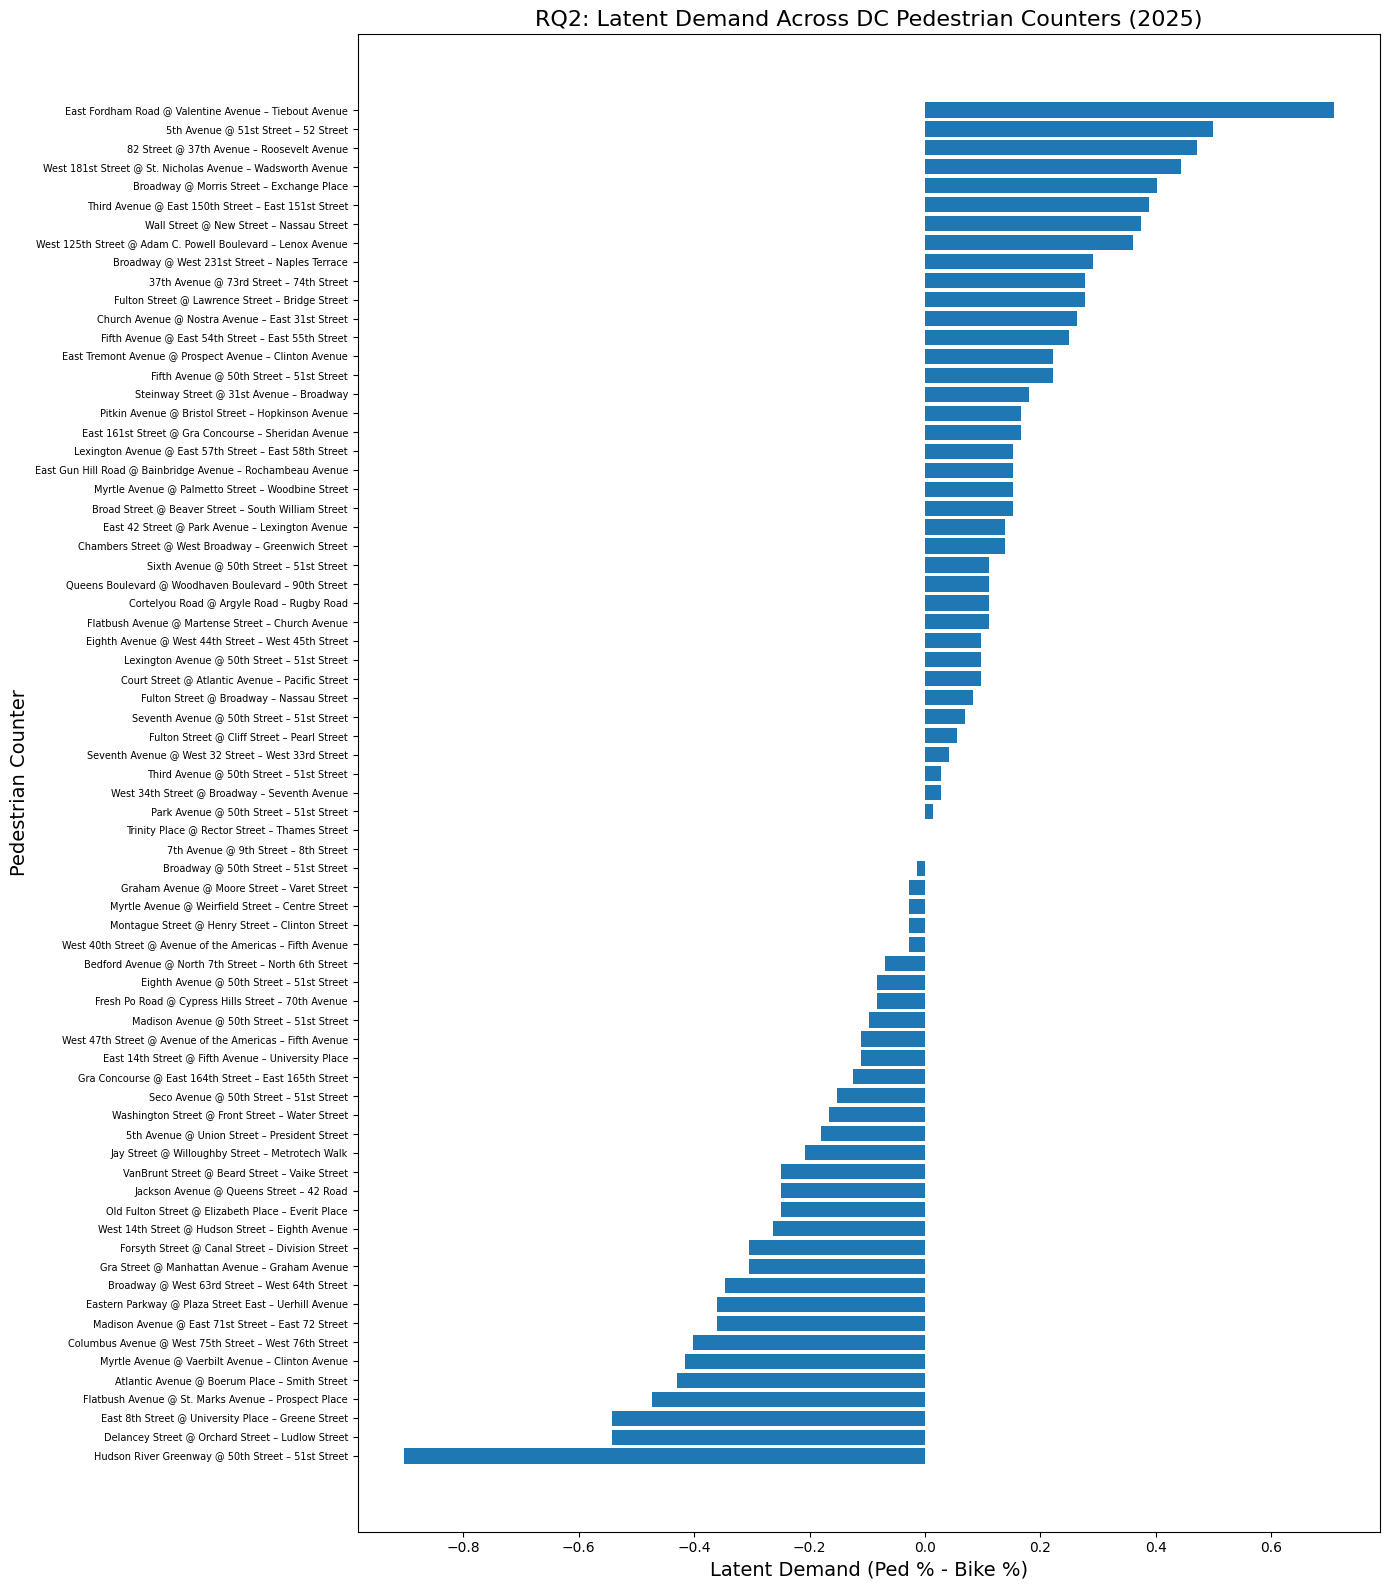

In [ ]:
import matplotlib.pyplot as plt

# Sort
rq2_sorted = rq2.sort_values("latent_demand", ascending=False)

plt.figure(figsize=(14, 16))  # tall + wide = most readable

plt.barh(
    rq2_sorted["ped_station"],
    rq2_sorted["latent_demand"],
)

plt.xlabel("Latent Demand (Ped % - Bike %)", fontsize=14)
plt.ylabel("Pedestrian Counter", fontsize=14)
plt.title("RQ2: Latent Demand Across NYC Pedestrian Counters (2025)", fontsize=16)

# Apply BOTH:
plt.yticks(fontsize=7, rotation=0)   # small + slight rotation
# If you want a 15° rotation, change to rotation=15

plt.gca().invert_yaxis()  # highest score at top
plt.tight_layout()
plt.show()


**RQ2 Scatter: Pedestrian vs Bikeshare Percentiles**

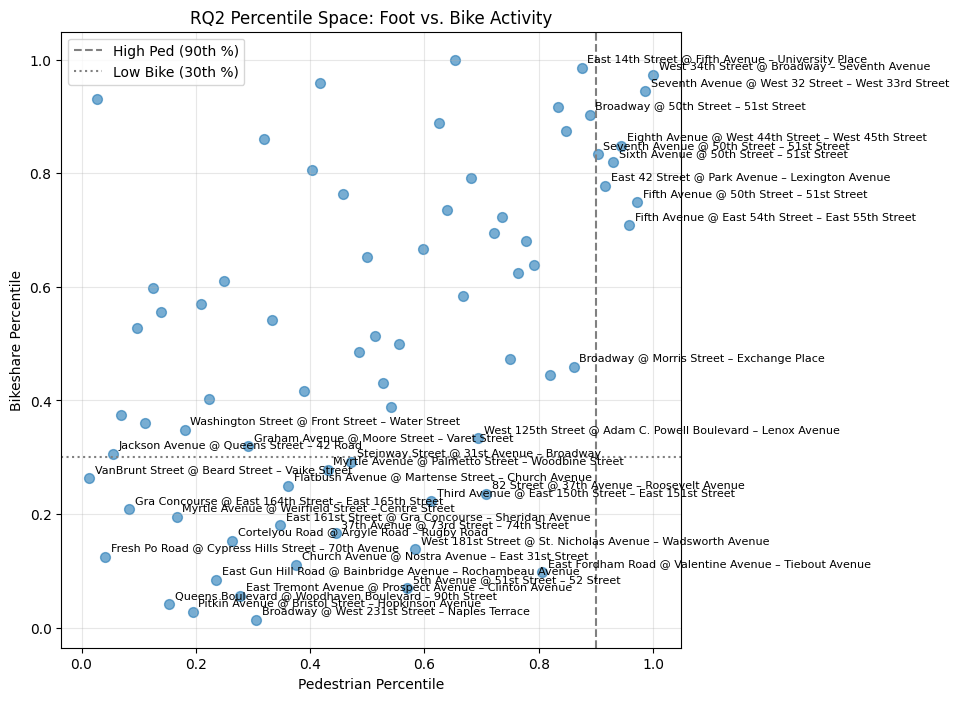

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

# Scatter with smaller markers and some transparency
plt.scatter(
    rq2["ped_percentile"],
    rq2["bike_percentile"],
    s=50,
    alpha=0.6
)

# Only label points with high pedestrian or low bike activity (adjust thresholds as needed)
for _, r in rq2.iterrows():
    if r["ped_percentile"] > 0.85 or r["bike_percentile"] < 0.35:
        plt.text(r["ped_percentile"] + 0.01, r["bike_percentile"] + 0.01, 
                 r["ped_station"], fontsize=8)

plt.xlabel("Pedestrian Percentile")
plt.ylabel("Bikeshare Percentile")
plt.title("RQ2 Percentile Space: Foot vs. Bike Activity")

# Add reference lines
plt.axvline(0.9, color='gray', linestyle='--', label="High Ped (90th %)")
plt.axhline(0.3, color='gray', linestyle=':',  label="Low Bike (30th %)")

plt.legend()
plt.grid(alpha=0.3)
plt.show()



**RQ3 Accessibility Gap Plot**

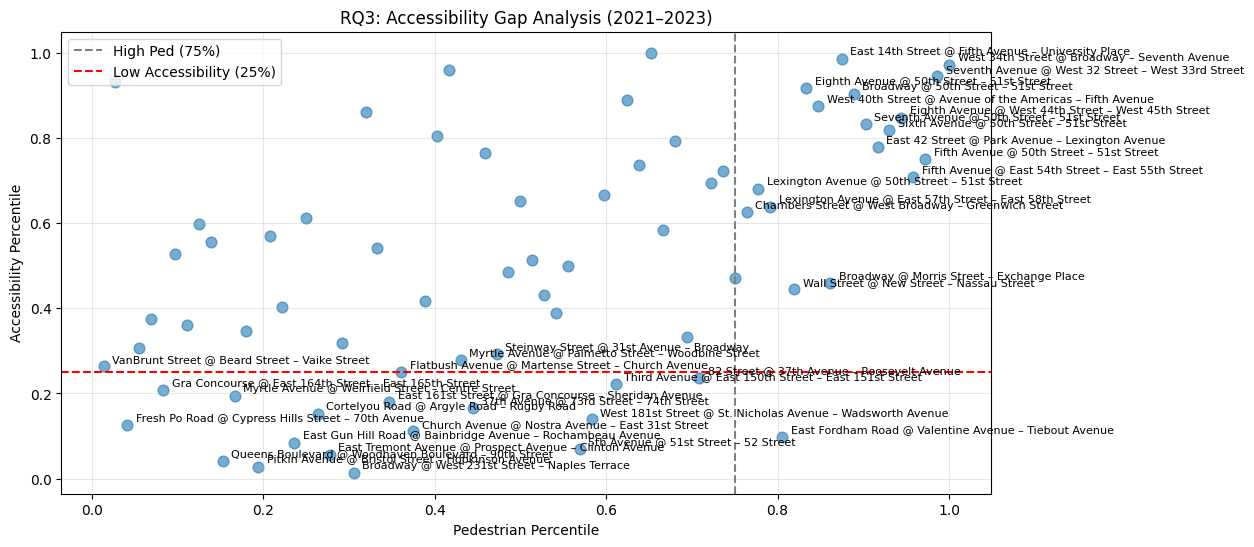

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Scatter with smaller markers and transparency
plt.scatter(
    rq2["ped_percentile"],
    rq2["accessibility_percentile"],
    s=60,
    alpha=0.6
)

# Label only points with high ped or low accessibility (adjust thresholds as needed)
for _, r in rq2.iterrows():
    if r["ped_percentile"] > 0.75 or r["accessibility_percentile"] < 0.3:
        plt.text(r["ped_percentile"] + 0.01, r["accessibility_percentile"] + 0.01, 
                 r["ped_station"], fontsize=8)

# Reference lines
plt.axvline(0.75, linestyle='--', color='gray', label="High Ped (75%)")
plt.axhline(0.25, linestyle='--', color='red', label="Low Accessibility (25%)")

plt.xlabel("Pedestrian Percentile")
plt.ylabel("Accessibility Percentile")
plt.title("RQ3: Accessibility Gap Analysis (2025)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

